In [63]:
# Import dependencies
import twitter_functions as tf # custom functions file

from nltk.featstruct import _default_fs_class
import twitter_functions as tf # custom functions file
import streamlit as st
from streamlit_metrics import metric, metric_row
from PIL import Image
import pandas as pd
import datetime as dt
import base64
import tweepy as tw
import yaml
import string
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import altair as alt


In [64]:
#-----------------------------------#
# 3) GET DATA FROM TWITTER API
#-----------------------------------#

## Set up Twitter API access
# Reference: https://gist.github.com/radcliff/47af9f6238c95f6ae239
# Load yml file to dictionary
credentials = yaml.load(open('./credentials.yml'), Loader=yaml.FullLoader)

# Define access keys and tokens
consumer_key = credentials['twitter_api']['consumer_key']
consumer_secret = credentials['twitter_api']['consumer_secret']
access_token = credentials['twitter_api']['access_token']
access_token_secret = credentials['twitter_api']['access_token_secret']

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit = True)

# define parameters for API request
search_word = "#rstats"
num_of_tweets = 300
include_retweets = False
language = "en"

if include_retweets == False:
    search_word = search_word + " -filter:retweets"

tweets = tw.Cursor(api.search,
                    q=search_word,
                    tweet_mode = "extended",
                    lang=language).items(num_of_tweets)

tweet_metadata = [[tweet.created_at, tweet.id, tweet.full_text, tweet.user.screen_name, tweet.retweet_count, tweet.favorite_count] for tweet in tweets]

In [65]:
# Store as dataframe
df_tweets = pd.DataFrame(data=tweet_metadata, columns=['created_at', 'id', 'full_text', 'user', 'rt_count', 'fav_count'])

# Add a new data variable
df_tweets['created_dt'] = df_tweets['created_at'].dt.date

# Add a new time variable
df_tweets['created_time'] = df_tweets['created_at'].dt.time

# Create a new text variable to do manipulations on 
df_tweets['clean_text'] = df_tweets.full_text

# Run function #2: Feature extraction
df_tweets = tf.feature_extract(df_tweets)

# Run function #3: Round 1 text cleaning (convert to lower, remove numbers, @, punctuation, numbers. etc.)
df_tweets['clean_text'] = df_tweets.clean_text.apply(tf.text_clean_round1)

# Run function #4: Round 2 text cleaning (create list of tokenized words)
#TODO NOT RUNNING -- FIX?
#df_tweets.clean_text  = tf.text_clean_round2(df_tweets.clean_text)

## Run function #5: Round 3 text cleaning (remove stop words)
df_tweets.clean_text  = tf.text_clean_round3(df_tweets.clean_text)

# Create list of words
words2 = df_tweets.clean_text.tolist()

# Method 1

In [57]:
# Reference: https://ourcodingclub.github.io/tutorials/topic-modelling-python/
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df_tweets['clean_text']).toarray()

# tf_feature_names tells us what word each column in the matrix represents
tf_feature_names = vectorizer.get_feature_names()

print(tf_feature_names)

['100daysofcode', 'analytics', 'bigdata', 'cloudcomputing', 'coding', 'data', 'datascience', 'datascientist', 'iiot', 'iot', 'java', 'javascript', 'linux', 'machinelearning', 'programming', 'python', 'r', 'reactjs', 'serverless', 'tensorflow', 'tidyverse']


In [58]:
number_of_topics = 10

model = LDA(n_components=number_of_topics, random_state=0)

model.fit(tf)

LatentDirichletAllocation(random_state=0)

In [66]:
def lda_topics(data, number_of_topics):
    # the vectorizer object will be used to transform text to vector form
    vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

    # apply transformation
    tf = vectorizer.fit_transform(data).toarray()

    # tf_feature_names tells us what word each column in the matrix represents
    tf_feature_names = vectorizer.get_feature_names()

    model = LDA(n_components=number_of_topics, random_state=0)

    return model.fit(tf)

lda_topics(df_tweets['clean_text'], 10)

In [68]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,machinelearning,12.1,r,43.1,python,70.7,tidyverse,51.1,data,41.7,iot,37.8,python,17.6,programming,9.1,datascience,0.1,serverless,7.1
1,datascience,9.5,datascience,29.6,coding,70.1,r,0.1,datascience,7.7,machinelearning,30.7,java,8.1,datascientist,1.1,python,0.1,100daysofcode,6.4
2,bigdata,4.4,tidyverse,0.1,analytics,69.3,data,0.1,python,0.1,python,29.5,100daysofcode,6.4,r,0.1,100daysofcode,0.1,bigdata,6.4
3,reactjs,2.1,machinelearning,0.1,bigdata,68.1,datascience,0.1,machinelearning,0.1,datascience,28.0,javascript,5.3,100daysofcode,0.1,bigdata,0.1,datascience,6.1
4,100daysofcode,0.1,bigdata,0.1,datascience,66.7,python,0.1,linux,0.1,javascript,25.2,bigdata,1.5,javascript,0.1,machinelearning,0.1,python,5.6
5,python,0.1,datascientist,0.1,100daysofcode,66.6,100daysofcode,0.1,tidyverse,0.1,100daysofcode,21.0,linux,1.1,iiot,0.1,serverless,0.1,analytics,5.1
6,javascript,0.1,programming,0.1,linux,66.1,bigdata,0.1,serverless,0.1,reactjs,20.2,datascience,0.1,python,0.1,analytics,0.1,linux,3.1
7,serverless,0.1,python,0.1,iot,65.4,machinelearning,0.1,bigdata,0.1,tensorflow,19.4,tensorflow,0.1,machinelearning,0.1,reactjs,0.1,tensorflow,3.1
8,analytics,0.1,100daysofcode,0.1,reactjs,65.0,serverless,0.1,100daysofcode,0.1,cloudcomputing,19.3,analytics,0.1,datascience,0.1,linux,0.1,data,3.1
9,linux,0.1,serverless,0.1,javascript,63.8,analytics,0.1,javascript,0.1,bigdata,18.1,reactjs,0.1,analytics,0.1,javascript,0.1,coding,2.1


# Method 2

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


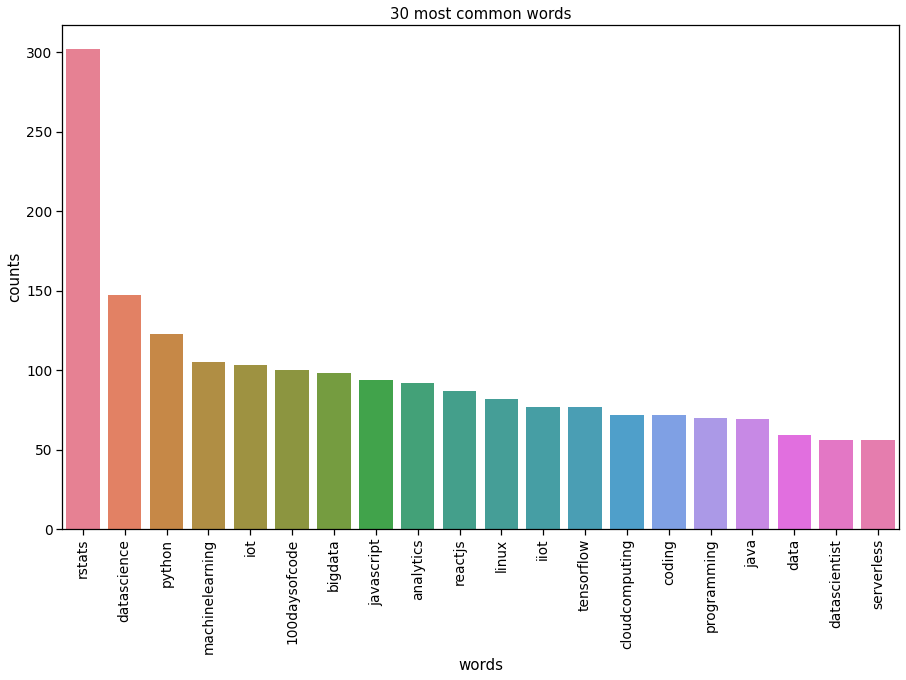

In [60]:
# Helper function
def plot_30_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='30 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed transcripts
count_data = count_vectorizer.fit_transform(df_tweets['clean_text'])

# Visualise the 30 most common words
plot_30_most_common_words(count_data, count_vectorizer)

In [61]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 30
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
rstats time tidyverse ill sas hand datascience charts results use im problems excel want covid19 know need sharing place adding packages like sign bring rbase holdposition tracker indiana demographics covidcast

Topic #1:
rstats tidyverse datascience data code like 100daysofmlcode new cybersecurity need using good academicchatter true package post way iibot science important updates cran function help artificialinteligence climatechange workflow column working game

Topic #2:
rstats data using datascience tidytuesday got great ggplot2 week want tidyverse source idea distribution r4ds map file shiny dataviz solar today new learn reference look api economic work come ideas

Topic #3:
rstats datascience iot bigdata python data machinelearning javascript linux reactjs iiot tidyverse tensorflow cloudcomputing security things blockchain tech4all osint darkweb rbloggers certification fundamentals anonymity connectivity training btc internet turkey covid19

Top